[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Denis-R-V/TSR/blob/main/notebooks/6.1.inference_local.ipynb)

# Система распознавания дорожных знаков на датасете RTSD

## Инференс (локальные данные)

In [1]:
# если работаем в колабе - монтируем диск, ставим fiftyone и kaggle
try:
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install fiftyone -q
    !pip install kaggle -q
    
    colab=True
except:
    colab=False

In [2]:
#import json
import os
#import random
#import re
import sys

import cv2
#import fiftyone as fo
#import matplotlib.patches as patches
import matplotlib.pyplot as plt
#import numpy as np
#import PIL
import torch
#import torch.nn as nn
#import torch.utils.data
#import torchvision
#import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
from PIL.JpegImagePlugin import JpegImageFile
#from pycocotools.coco import COCO
#from torchvision.models import resnet152
#from torchvision.models.detection import FasterRCNN
#from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.transforms import v2

sys.path.append('../src')
from execute import Builder

#%matplotlib inline

### Пути к данным и параметры

In [3]:
device_id = 0
device = f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu'

dataset_path = 'data/raw/RTSD' if colab else os.path.join('..', 'data', 'raw', 'RTSD')
models_path = '../content/drive/MyDrive/TSR/models' if colab else os.path.join('..', 'models')

detector_file = 'chkpt_detector_resnet50_v2_augmented_b8_5.pth'
classifier_file = 'classifier_resnet152_add_signs_bg100_tvs_randomchoice_perspective_colorjitter_resizedcrop_erasing_adam_001_sh_10_06_model_29.pth'

detector_threshold = 0.9
classifier_threshold = 0.9
debug_mode = False

### Загрузка модели (детектор и классификатор)

In [4]:
model = Builder(device=device,
                class2label_path=os.path.join(dataset_path, 'label_map.json'),
                detector_path=os.path.join(models_path, detector_file),
                classifier_path=os.path.join(models_path, classifier_file),
                detector_threshold=detector_threshold,
                classifier_threshold=classifier_threshold,
                debug_mode=debug_mode)

Добавить файлы со знаками
Для FasterRCNN с backbone resnet50v2 загружены веса из ..\models\chkpt_detector_resnet50_v2_augmented_b8_5.pth
Загружен классификатор из ..\models\classifier_resnet152_add_signs_bg100_tvs_randomchoice_perspective_colorjitter_resizedcrop_erasing_adam_001_sh_10_06_model_29.pth


### Визиализация предсказания модели на одном изображении

c:\Users\denis\anaconda3\envs\ds_env\Lib\site-packages\torchvision\transforms\v2\functional\_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(


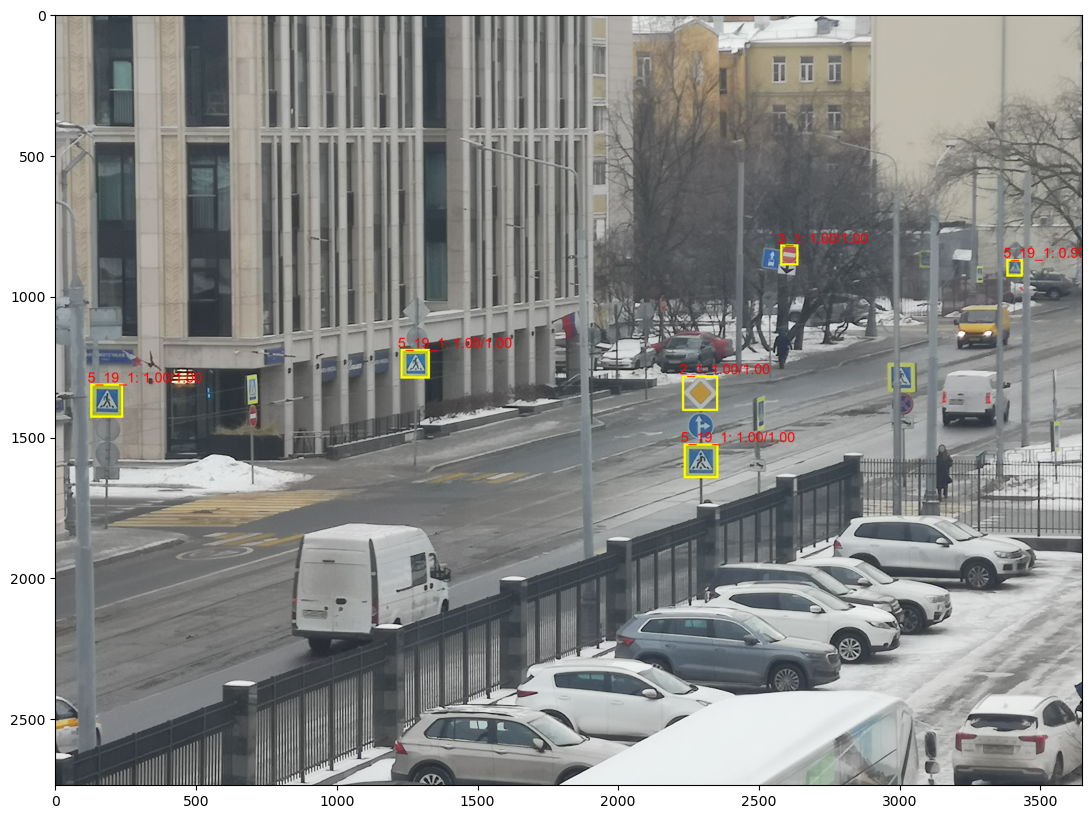

2_1: Главная дорога
3_1: Въезд запрещён
5_19_1: Пешеходный переход


In [8]:
def get_visualized_prediction(model, img, detector_threshold: float = None, classifier_threshold: float = None, debug_mode: float = None):
    '''
    на вход подается модель, путь к изображению или изображение, открытое PIL
    на выходе отрисовывается изображение с нанесенными рамками, ID классов, 
    уверенностями детекций и вероятностями класса для одного изображения
    при debug_mode=True выводятся детекции с любой уверенностью и 
    0-й класс (фон) тоже выводится
    '''

    assert isinstance(img, str) or isinstance(img, JpegImageFile), \
        'При визуализации предсказания на одном изображении подается путь к изображению или изображение, открытое PIL'

    # Если заданы threshold или debug_mode - меняем параметры модели
    if detector_threshold: model.detector_threshold = detector_threshold
    if classifier_threshold: model.classifier_threshold = classifier_threshold
    if debug_mode: model.debug_mode = debug_mode

    # загрузка изображения, если на вход подан путь
    img = model.preprocessing_single(img)

    # получение предсказаний модели
    bboxes, labels, detector_scores, classifier_scores = model.predict_single(img)

    # получаем шрифты
    if sys.platform == 'win32':
        fonts_path = 'C:\Windows\Fonts'
    elif sys.platform == 'darwin':
        fonts_path = '/System/Library/Fonts/'
    else:
        print('Требуется указать путь к шрифтам')
        return None
    
    font = ImageFont.truetype(os.path.join(fonts_path, 'arial.ttf'), size=50)

    # Отрисовка рамок и трешхолдов
    pencil = ImageDraw.Draw(img)
    for i in range(len(bboxes)):
        pencil.rectangle(bboxes[i], fill = None, width=8, outline='yellow')
    for i in range(len(bboxes)):    
        text_x = bboxes[i][0] - 10
        text_y = bboxes[i][1] - 50
        mark = "{0}: {1:1.2f}/{2:1.2f}".format(str(model.class2label_map[labels[i]]), detector_scores[i], classifier_scores[i])
        pencil.text((text_x, text_y), mark, font=font, fill = 'red')

    # Выводим изображение (не обязательно, можно вывести PIL)
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 10)
    ax.imshow(img)
    plt.show()

    # Описание знаков
    signs_in_predict = sorted(list(set([model.class2label_map[label] for label in labels])))
    description_predict = ["{}: {}".format(sign, model.labels2names_map[sign]) for sign in signs_in_predict]
    print('\n'.join(description_predict))

    return None

img = os.path.join('..','images','image_for_predict','p20_1.jpg')
img = get_visualized_prediction(model, img, detector_threshold=None, classifier_threshold=None, debug_mode=None)

In [7]:




#img_path = 'data\image_for_predict\image1.jpg'
#img_path = 'data\image_for_predict\image2.jpg'
img_path = 'data\image_for_predict\p20_1.jpg'
#img_path = 'data\image_for_predict\p20_2.jpg'
#img_path = 'data\image_for_predict\p20_3.jpg'
#img_path = 'data\image_for_predict\p20_4.jpg'
#img_path = 'data\image_for_predict\screen1.jpg'
#img_path = 'data\image_for_predict\screen2.jpg'
#img_path = 'rtsd-frames/autosave16_10_2012_08_58_25_5.jpg'  есть 0
#img_path = 'rtsd-frames/autosave01_02_2012_09_24_03.jpg'  есть 0

temp = get_visualized_prediction(model, img_path)

FileNotFoundError: [Errno 2] No such file or directory: 'data\\image_for_predict\\p20_1.jpg'

In [5]:
img = os.path.join('..','images','image_for_predict','p20_1.jpg')
#img = Image.open(os.path.join('..','images','image_for_predict','p20_1.jpg'))
#img = cv2.imread(os.path.join('..','images','image_for_predict','p20_1.jpg'))

model.predict_single(img)

c:\Users\denis\anaconda3\envs\ds_env\Lib\site-packages\torchvision\transforms\v2\functional\_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(


([[2233.2048, 1522.1533, 2356.9817, 1645.7714],
  [2227.8762, 1280.141, 2355.2632, 1406.4333],
  [1227.885, 1186.5234, 1331.2573, 1291.1202],
  [125.881615, 1309.9249, 242.52687, 1430.9084],
  [2576.8518, 815.192, 2640.8594, 889.04095],
  [3379.4834, 867.30457, 3437.8628, 929.774]],
 [7, 1, 7, 7, 69, 7],
 [0.99961877, 0.99961865, 0.99941504, 0.9990386, 0.9963568, 0.9852519],
 [0.9999935626983643,
  0.9999223947525024,
  0.9999983310699463,
  1.0,
  0.9974201917648315,
  0.9851073622703552])

c:\Users\denis\anaconda3\envs\ds_env\Lib\site-packages\torchvision\transforms\v2\functional\_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(


([[2233.2048, 1522.1533, 2356.9817, 1645.7714],
  [2227.8762, 1280.141, 2355.2632, 1406.4333],
  [1227.885, 1186.5234, 1331.2573, 1291.1202],
  [125.881615, 1309.9249, 242.52687, 1430.9084],
  [2576.8518, 815.192, 2640.8594, 889.04095],
  [3379.4834, 867.30457, 3437.8628, 929.774]],
 [7, 1, 7, 7, 69, 7],
 [0.99961877, 0.99961865, 0.99941504, 0.9990386, 0.9963568, 0.9852519],
 [0.9999935626983643,
  0.9999223947525024,
  0.9999983310699463,
  1.0,
  0.9974201917648315,
  0.9851073622703552])

In [ ]:
# функция еще не готова
# формирование аннотации
def get_predict_anno(images_path, img_name, threshold):

    if img_name == None:
        with open(os.path.join(dataset_path, 'val_anno.json'), 'r') as read_file:
            val_anno = json.load(read_file)
        read_file.close()
        img_name = val_anno.get('images')[random.randint(0, len(val_anno.get('images')))].get('file_name')

    pred_boxes, pred_labels, pred_scores = get_prediction_one_image(images_path, img_name, threshold)
    anno = {}

    images = []
    image_item = {}
    image_item['id'] = 0
    img = Image.open(os.path.join(images_path, img_name))
    transforms=torchvision.transforms.ToTensor()
    img = transforms(img).to(device)
    image_item['width'] = img.shape[2]
    image_item['height'] = img.shape[1]
    image_item['file_name'] = img_name
    images.append(image_item)
    anno['images'] = images

    annotations = []
    for i in range(len(pred_boxes)):
        anno_item = {}
        anno_item['id'] = i
        anno_item['image_id'] = 0
        anno_item['category_id'] = int(pred_labels[i])
        anno_item['area'] = (float(pred_boxes[i][2]) - float(pred_boxes[i][0]))*(float(pred_boxes[i][3]) - float(pred_boxes[i][1]))     # Исправить, так как COCO формат
        anno_item['bbox'] = [float(pred_boxes[i][0]), float(pred_boxes[i][1]), float(pred_boxes[i][2]) - float(pred_boxes[i][0]), float(pred_boxes[i][3]) - float(pred_boxes[i][1])]
        anno_item['iscrowd'] = 0
        annotations.append(anno_item)
    anno['annotations'] = annotations
    
    anno['categories'] = [{'id': 1, 'name': 'sign'}]

    with open(os.path.join(dataset_path, 'predicted_anno.json'), 'w') as f:
        json.dump(anno, f)#ensure_ascii=False, indent=4)
    f.close()

    # загрузка изображения в fiftyone
    data_path = images_path      # можно не указывать, если в JSON путь совпадает

    # The path yo the COCO labels JSON file
    labels_file = "train_anno_bin_class.json"
    labels_path = os.path.join(dataset_path, 'predicted_anno.json')


    # Import the dataset
    dataset = fo.Dataset.from_dir(
        dataset_type=fo.types.COCODetectionDataset,
        data_path=data_path,
        labels_path=labels_path
    )
    # Визуализация набора данных
    session = fo.launch_app(dataset)

    return anno

# Разбор с предыдущего

In [ ]:
# Простой рисовальщик
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(10,10)
    a.imshow(img)
    for box in (target):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 1,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
#img, target = my_dataset[25]
img_name = 'rtsd-frames/autosave09_10_2012_13_42_22_2.jpg'
threshold = 0.1
prediction = get_prediction_one_image(dataset_path, img_name, threshold)
#img = prediction[0]
target = prediction[1]
#img = img.permute(1, 2, 0).cpu().detach().numpy()
#img = img*255
#img = img.astype(np.uint8)
img = Image.open(os.path.join(dataset_path, img_name))
display(prediction[2])
plot_img_bbox(img, target)

In [ ]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(10,10)
    a.imshow(img)
    for box in (target):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 1,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
#img, target = my_dataset[25]
img_name = 'rtsd-frames/autosave16_10_2012_10_20_27_0.jpg'
threshold = 0.1
prediction = get_prediction_one_image(dataset_path, img_name, threshold)
img = prediction[0]
target = prediction[1]
img = img.permute(1, 2, 0).cpu().detach().numpy()
img = img*255
img = img.astype(np.uint8)
display(prediction[2])
plot_img_bbox(img, target)

In [ ]:
def get_predict_anno(images_path, img_name, threshold):

    if img_name == None:
        with open(os.path.join(dataset_path, 'val_anno.json'), 'r') as read_file:
            val_anno = json.load(read_file)
        read_file.close()
        img_name = val_anno.get('images')[random.randint(0, len(val_anno.get('images')))].get('file_name')

    _, pred_boxes, pred_labels, pred_scores = get_prediction_one_image(images_path, img_name, threshold)
    
    anno = {}

    images = []
    image_item = {}
    image_item['id'] = 0
    img = Image.open(os.path.join(images_path, img_name))
    transforms=torchvision.transforms.ToTensor()
    img = transforms(img).to(device)
    image_item['width'] = img.shape[2]
    image_item['height'] = img.shape[1]
    image_item['file_name'] = img_name
    images.append(image_item)
    anno['images'] = images

    annotations = []
    for i in range(len(pred_boxes)):
        anno_item = {}
        anno_item['id'] = i
        anno_item['image_id'] = 0
        anno_item['category_id'] = int(pred_labels[i])
        anno_item['area'] = (float(pred_boxes[i][2]) - float(pred_boxes[i][0]))*(float(pred_boxes[i][3]) - float(pred_boxes[i][1]))     # Исправить, так как COCO формат
        anno_item['bbox'] = [float(pred_boxes[i][0]), float(pred_boxes[i][1]), float(pred_boxes[i][2]) - float(pred_boxes[i][0]), float(pred_boxes[i][3]) - float(pred_boxes[i][1])]
        anno_item['iscrowd'] = 0
        annotations.append(anno_item)
    anno['annotations'] = annotations
    
    with open(os.path.join(dataset_path, 'train_anno_reduced.json'), 'r') as read_file:
        categories = json.load(read_file)['categories']
    read_file.close()
    categories.insert(0, {'id': 0, 'name': '0'})
    anno['categories'] = categories

    with open(os.path.join(dataset_path, 'predicted_anno.json'), 'w') as f:
        json.dump(anno, f)#ensure_ascii=False, indent=4)
    f.close()

    # загрузка изображения в fiftyone
    data_path = images_path      # можно не указывать, если в JSON путь совпадает

    # The path yo the COCO labels JSON file
    labels_file = "train_anno_bin_class.json"
    labels_path = os.path.join(dataset_path, 'predicted_anno.json')


    # Import the dataset
    dataset = fo.Dataset.from_dir(
        dataset_type=fo.types.COCODetectionDataset,
        data_path=data_path,
        labels_path=labels_path
    )
    # Визуализация набора данных
    session = fo.launch_app(dataset)

    return anno

In [ ]:
threshold = 0.5
#img_name = None
img_name = 'image_for_predict/p20_5.jpg'
#img_name = 'rtsd-frames/autosave16_10_2012_08_58_25_5.jpg'
#img_name = 'rtsd-frames/autosave01_02_2012_09_24_03.jpg'
#prediction_anno = get_predict_anno(dataset_path, , threshold)
prediction_anno = get_predict_anno(dataset_path, img_name, threshold)

### Детекция знаков на списке изображений


In [ ]:
def get_prediction_list_images(images_path, img_list, threshold):
    detector.eval()
    transforms=torchvision.transforms.ToTensor()
    images = []
    for image in img_list:
        img = Image.open(os.path.join(images_path, image)) 
        img = transforms(img).to(device)
        images.append(img)
            
    predictions = detector(images)
    
    results = []
    for prediction in predictions:
        result = []
        pred_boxes = [[i[0], i[1], i[2], i[3]] for i in list(prediction['boxes'].detach().cpu().numpy())]
        pred_labels = list(prediction.get('labels').cpu().numpy())
        pred_scores = list(prediction.get('scores').detach().cpu().numpy())

        pred_tr = [pred_scores.index(x) for x in pred_scores if x > threshold][-1]
        pred_labels = pred_labels[:pred_tr+1]
        pred_boxes = pred_boxes[:pred_tr+1]
        pred_scores = pred_scores[:pred_tr+1]
        result.append(pred_boxes)
        result.append(pred_labels)
        result.append(pred_scores)
        results.append(result)
    #boxes = []
    #for i in range(num_objs):
    #    min = coco_annotation[i]['bbox'][0]
    #    ymin = coco_annotation[i]['bbox'][1]
    #    xmax = xmin + coco_annotation[i]['bbox'][2]
    #    ymax = ymin + coco_annotation[i]['bbox'][3]
    #    boxes.append([xmin, ymin, xmax, ymax])
    
    return results#pred_boxes, pred_labels, pred_scores

time_start = time.time()
img_list = ['rtsd-frames/autosave16_10_2012_08_58_25_5.jpg',
            'rtsd-frames/autosave01_02_2012_09_24_03.jpg']
threshold = 0.1
prediction = get_prediction_list_images(dataset_path, img_list, threshold)
time_end = time.time()
prediction, time_end-time_start

In [ ]:
def get_predict_anno_list_images(images_path, img_list, threshold):

    if img_list == None:
        with open(os.path.join(dataset_path, 'val_anno.json'), 'r') as read_file:
            val_anno = json.load(read_file)
        read_file.close()
        img_list = [val_anno.get('images')[random.randint(0, len(val_anno.get('images')))].get('file_name')]

    predict = []
    for image in img_list:
        one_predict = get_prediction_one_image(dataset_path, image, threshold)
        predict.append(one_predict)
    anno = {}
    anno_item_id = 0

    transforms=torchvision.transforms.ToTensor()
    images = []
    annotations = []
    for i in range(len(predict)):
        img = Image.open(os.path.join(images_path, img_list[i]))
        img = transforms(img).to(device)
        
        image_item = {}
        image_item['id'] = i
        image_item['width'] = img.shape[2]
        image_item['height'] = img.shape[1]
        image_item['file_name'] = img_list[i]
        images.append(image_item)

        prediction = predict[i]
        #for j in range(len(prediction[0])):
        for j in range(len(prediction[1])):
            
            anno_item = {}
            anno_item['id'] = anno_item_id
            anno_item_id += 1
            anno_item['image_id'] = i
            #anno_item['category_id'] = int(prediction[1][j])
            anno_item['category_id'] = int(prediction[2][j])
            #anno_item['area'] = (float(prediction[0][j][2]) - float(prediction[0][j][0]))*(float(prediction[0][j][3]) - float(prediction[0][j][1]))
            anno_item['area'] = (float(prediction[1][j][2]) - float(prediction[1][j][0]))*(float(prediction[1][j][3]) - float(prediction[1][j][1]))
            #anno_item['bbox'] = [float(prediction[0][j][0]), float(prediction[0][j][1]), float(prediction[0][j][2]) - float(prediction[0][j][0]), float(prediction[0][j][3]) - float(prediction[0][j][1])]
            anno_item['bbox'] = [float(prediction[1][j][0]), float(prediction[1][j][1]), float(prediction[1][j][2]) - float(prediction[1][j][0]), float(prediction[1][j][3]) - float(prediction[1][j][1])]
            anno_item['iscrowd'] = 0
            annotations.append(anno_item)
    
    anno['images'] = images
    anno['annotations'] = annotations
    
    with open(os.path.join(dataset_path, 'train_anno_reduced.json'), 'r') as read_file:
        categories = json.load(read_file)['categories']
    read_file.close()
    categories.insert(0, {'id': 0, 'name': '0'})
    anno['categories'] = categories


    result = predict

    with open(os.path.join(dataset_path, 'predicted_anno.json'), 'w') as f:
        json.dump(anno, f)#ensure_ascii=False, indent=4)
    f.close()

    # загрузка изображения в fiftyone
    data_path = images_path      # можно не указывать, если в JSON путь совпадает

    # The path yo the COCO labels JSON file
    labels_path = os.path.join(dataset_path, 'predicted_anno.json')


    # Import the dataset
    dataset = fo.Dataset.from_dir(
        dataset_type=fo.types.COCODetectionDataset,
        data_path=data_path,
        labels_path=labels_path
    )
    # Визуализация набора данных
    session = fo.launch_app(dataset)

    return result#annotations


threshold = 0
img_list = ['image_for_predict/image1.jpg',                     # картинка из интернета
            'image_for_predict/image2.jpg',                     # картинка из интернета
            'image_for_predict/screen1.jpg',                    # скрин я яндекс карт
            'image_for_predict/screen2.jpg',                    # скрин я яндекс карт
            'image_for_predict/p20_1.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_2.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_3.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_4.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_5.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_6.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_7.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_8.jpg',                      # снимок из окна кабинета
            'image_for_predict/p20_9.jpg',                      # снимок из окна кабинета
            'rtsd-frames/autosave16_10_2012_08_58_25_5.jpg',    # тестовая выборка
            'rtsd-frames/autosave01_02_2012_09_24_03.jpg'       # тестовая выборка 
            ]

#prediction_anno = get_predict_anno_list_images(dataset_path, None, threshold)
prediction_anno = get_predict_anno_list_images(dataset_path, img_list, threshold=0.9)
prediction_anno

In [ ]:
#Load val dataset COCO
# загрузка датасета
import fiftyone as fo
# The directiry containing the source images
data_path = dataset_path      # можно не указывать, если в JSON путь совпадает

# The path yo the COCO labels JSON file
val_anno_file = "val_anno_bin_class.json"
val_anno_path = os.path.join(dataset_path, val_anno_file)


# Import the dataset
val_dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=val_anno_path
)

In [ ]:
predictions_view = val_dataset.take(50, seed=42)

In [ ]:
# Add and evaluating Faster-RCNN detections
# Faster-RCNN detections can be calculated and added to every sample of the dataset in a new field
import torch, torchvision
from torchvision.transforms import functional as func
import json
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image

# Load the pretrained PyTorch model
def load_model_detection(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model =torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

num_classes = 2
model = load_model_detection(num_classes)

# Run the model on GPU if it is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Загрузка весов модели
checkpoint = torch.load('checkpoints/chkpt_detector_resnet50_augmented_2.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

classes = predictions_view.default_classes

# Add predictions
n=0
for sample in predictions_view:
    image = Image.open(sample.filepath)
    image = func.to_tensor(image).to(device)
    c,h,w = image.shape
    preds = model([image])[0]
    labels = preds['labels'].cpu().detach().numpy()
    scores = preds['scores'].cpu().detach().numpy()
    boxes = preds['boxes'].cpu().detach().numpy()
    detections = []
    for label, score, box in zip (labels, scores, boxes):
        # Compute relative bounding box coordinates
        x1, y1, x2, y2 = box
        rel_box = [x1/w, y1/h, (x2-x1)/w, (y2-y1)/h]
        detections.append(fo.Detection(label=classes[label],
                                        bounding_box=rel_box,
                                        confidence=score
                                        )
                            )
    sample['faster_rcnn'] = fo.Detections(detections=detections)
    sample.save()